# A Faster-RCNN and NLP implementation for detecting the grocery products on a receipt

The main idea behind this model is the fact, that, when humans look at a receipt and are searching for the products, they can use the following knowledge to identify these:

- The layout of a receipt 
- special keyword as the name of food

This model tries to mimic this knowledge base, by not only embedding the bounding box position of a potential product via Faster-RCNN, but also the keyword context via RNN and OCR into the decision process:

![diagram](Rscanner.png)

This notebook was created using the following ressources:
- https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439
- https://arxiv.org/pdf/1506.01497.pdf
- https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd

Written in August 2020 by Luan Ademi for the GroceryListPredictor Project participating in the German National Artificial Intelligence Contest.

### Attention: This notebook is very demanding in computational power and needs around 5 GB of VRAM

## Importing the necessary libraries

In [1]:
import torch
import numpy as np
import torchvision
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pytesseract

device = torch.device("cuda")

## Reading in an example image

(4032, 3024, 3)


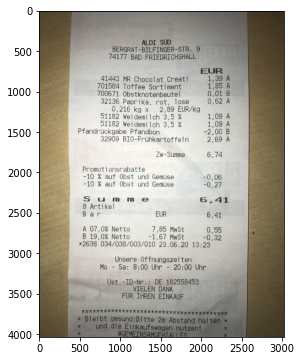

In [2]:
img0 = cv2.imread("img.jpg")
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(9, 6))
print(img0.shape)
plt.imshow(img0)
plt.show()

## Defining the bounding boxes for the products
Here, we are labeling the products in the receipt we use as an example with a bounding box and the corresponding class.

In [3]:
bbox0 = np.array([[800, 1000, 900, 1860],[900, 1000, 990, 1800],[990, 1000, 1080, 1750],[1080, 1000, 1180, 1880],[1260, 1000, 1360, 1800],[1360, 1000, 1460, 1800],[1540, 1000, 1650, 1870]]) 
labels = np.array([1,1,1,1,1,1,1]) # 0: background, 1: product, 2: store

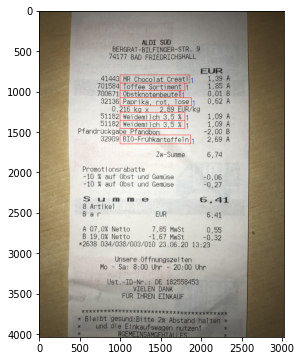

In [4]:
img0_clone = np.copy(img0)
for i in range(len(bbox0)):
    cv2.rectangle(img0_clone, (bbox0[i][1], bbox0[i][0]), (bbox0[i][3], bbox0[i][2]), color=(255,0,0), thickness=3)
    cv2.putText(img0_clone, str(int(labels[i])), (bbox0[i][3], bbox0[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,255),thickness=3) 
plt.figure(figsize=(9, 6))
plt.imshow(img0_clone)
plt.show()

## Resize the image and the bounding boxes (800, 800)
The feature extractor model is based on VGG16 and expects an image size of 800x800. Hence, we are going to resize it and it's corresponding bounding boxes

In [5]:
img = cv2.resize(img0, dsize=(800,800), interpolation=cv2.INTER_CUBIC)

In [6]:
# resize the bounding boxes
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox = []
for box in bbox0:
    box = [int(a * b) for a, b in zip(box, ratioLst)] 
    bbox.append(box)
bbox = np.array(bbox)
print(bbox)

[[158 264 178 492]
 [178 264 196 476]
 [196 264 214 462]
 [214 264 234 497]
 [250 264 269 476]
 [269 264 289 476]
 [305 264 327 494]]


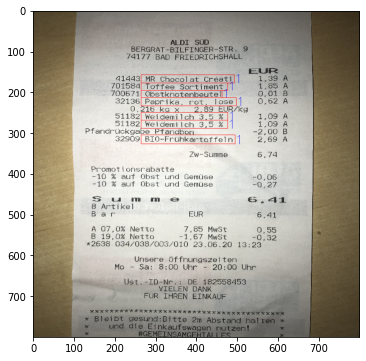

In [7]:
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), color=(255,0,0), thickness=1)
    cv2.putText(img_clone, str(int(labels[i])), (bbox[i][3], bbox[i][2]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),thickness=1)
plt.figure(figsize=(9, 6))
plt.imshow(img_clone)
plt.show()

## Generating the featuremap extractor model
As already mentioned, we are going to use a part of the pretrained VGG16 model for that job.

In [8]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print(fe)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [9]:
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800] 
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800//16:   #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

torch.Size([1, 3, 800, 800])
30
512


In [10]:
faster_rcnn_fe_extractor = torch.nn.Sequential(*req_features).to(device)

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
print(imgTensor.size())
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 3, 800, 800])
torch.Size([1, 512, 50, 50])


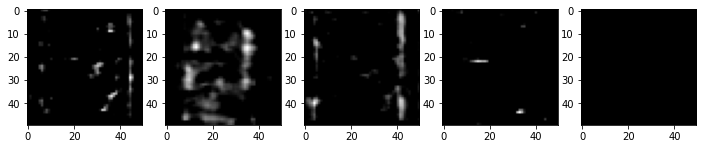

In [12]:
# drawing the featuremaps
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12,4))
figNo = 1
for i in range(5):
    fig.add_subplot(1,5, figNo)
    plt.imshow(imgArray[i], cmap="gray")
    figNo += 1
plt.show()

## Generating the anchor boxes
Faster-RCNN basically consists of a series of predictions of different areas in an image. These areas are called anchor boxes. They are equally distributed across the image. We are going to create 2500 anchorpoints and 22500 anchor boxes (9 anchor boxes per anchorpoint)

In [13]:
fe_size = (800//16)
ctr_x = np.arange(16, (fe_size+1) * 16, 16)
ctr_y = np.arange(16, (fe_size+1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [14]:
index = 0
ctr = np.zeros((fe_size**2, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index +=1
print(ctr.shape)

(2500, 2)


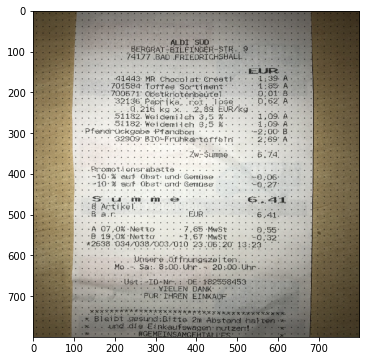

In [15]:
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(0, 0, 0), thickness=1)
plt.imshow(img_clone)
plt.show()

In [16]:
ratios = [0.1, 0.1, 0.1]
scales = [8, 16, 32]
sub_sample = 8
anchor_boxes = np.zeros( ((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1./ ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)

(22500, 4)


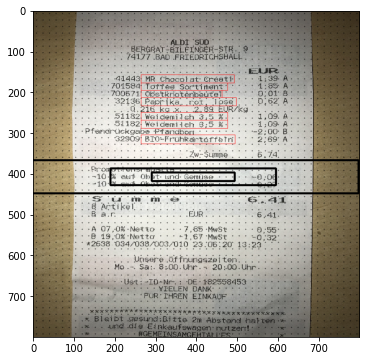

In [17]:
# Drawing the anchorboxes
img_clone = np.copy(img)
for i in range(11025, 11034):
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0,y0), (x1,y1), color=(0,0,0), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), color=(255,0,0), thickness=1)
    
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(0, 0, 0), thickness=1)
    
plt.figure(figsize=(9, 6))
plt.imshow(img_clone)
plt.show()

In [18]:
# check if the anchorboxes are completely in the image (800, 800)
index_inside = np.where(
        (anchor_boxes[:, 0] >= 0) &
        (anchor_boxes[:, 1] >= 0) &
        (anchor_boxes[:, 2] <= 800) &
        (anchor_boxes[:, 3] <= 800)
    )[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside] # an array containing all valid anchor boxes, which are in the image
print(valid_anchor_boxes.shape)

(8928,)
(8928, 4)


## Calculate the IOU (Intersection over unit)
We are going to calculate the IOU of each valid anchorbox. This number basically describes the "accuracy" of a anchor box, by looking at the intersecting area of the ground truth bounding box and the valid anchor box.

In [19]:
ious = np.empty((len(valid_anchor_boxes), len(bbox)), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(8928, 7)


In [20]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])] # the iou values of the most accurate valid anchorboxes
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0] # the valid anchorboxes (id) with the highest iou (the most accurate ones)
print(gt_argmax_ious)

[3942 3948 3666 3960 3978 3984 3996]
[0.8783562  0.69461256 0.57103175 0.3891294  0.59854966 0.8568451
 0.6087714 ]
[3666 3668 3670 3942 3944 3946 3948 3950 3952 3960 3962 3964 3966 3968
 3970 3978 3980 3982 3984 3986 3988 3996 3998 4000 4248 4250 4252 4254
 4256 4258 4284 4286 4288]


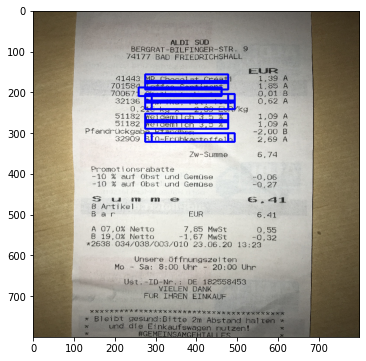

In [21]:
# Drawing the anchorboxes with the highest IOU
img_clone = np.copy(img)
for i in gt_argmax_ious:
    y0, x0, y1, x1 = valid_anchor_boxes[i].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0, 0, 255), thickness=3) 

plt.figure(figsize=(9, 6))
plt.imshow(img_clone)
plt.show()  

In [22]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8928,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


## Labeling the valid anchorboxes

In [23]:
label = np.empty((len(index_inside), ), dtype=np.int32) # an array which labels every valid anchorbox
label.fill(-1) # initialze every anchorbox to the class background
print(label.shape)

(8928,)


In [24]:
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1 # the anchorboxes with the highest iou are labeled as class 1
label[max_ious >= pos_iou_threshold] = 1 # the anchorboxes in a custom threshold too
label[max_ious < neg_iou_threshold] = 0

In [25]:
n_sample = 256
pos_ratio = 0.5
n_pos = pos_ratio * n_sample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1
    
n_neg = n_sample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

In [26]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose() # an array containing the position of the valid anchorboxes
print(anchor_locs.shape)

(8928, 4)
(8928, 4)


In [27]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


## Creating the region propsal network (RPN)

In [28]:
import torch.nn as nn

# the Region Proposal Network

class RPN(nn.Module):
    def __init__(self, in_channels, mid_channels, n_anchor):
        super(RPN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()

        self.reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0).to(device)
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()

        self.cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0).to(device)
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
    
    def forward(self, out_map):
        x = self.conv1(out_map) 
        pred_anchor_locs = self.reg_layer(x)
        pred_cls_scores = self.cls_layer(x)
        return pred_anchor_locs, pred_cls_scores

In [29]:
in_channels = 512 # depends on the output feature map. in vgg 16 it is equal to 512
mid_channels = 512
n_anchor = 9  # Number of anchors at each location (9)

rpn = RPN(in_channels, mid_channels, n_anchor).to(device)

In [30]:
pred_anchor_locs, pred_cls_scores = rpn(out_map.to(device)) # out_map = faster_rcnn_fe_extractor(imgTensor)
print(pred_anchor_locs.shape, pred_cls_scores.shape)

torch.Size([1, 36, 50, 50]) torch.Size([1, 18, 50, 50])


In [31]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)

pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores.shape)

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)

pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)

torch.Size([1, 22500, 4])
torch.Size([1, 50, 50, 18])
torch.Size([1, 22500])
torch.Size([1, 22500, 2])


In [32]:
rpn_loc = pred_anchor_locs[0]
rpn_score = pred_cls_scores[0]

gt_rpn_loc = torch.from_numpy(anchor_locations)
gt_rpn_score = torch.from_numpy(anchor_labels)

print(rpn_loc.shape, rpn_score.shape, gt_rpn_loc.shape, gt_rpn_score.shape)

torch.Size([22500, 4]) torch.Size([22500, 2]) torch.Size([22500, 4]) torch.Size([22500])


In [33]:
import torch.nn.functional as F
rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_score.long().to(device), ignore_index = -1)
print(rpn_cls_loss)

tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward>)


In [34]:
pos = gt_rpn_score > 0
mask = pos.unsqueeze(1).expand_as(rpn_loc)
print(mask.shape)

# take those bounding boxes which have positve labels
mask_loc_preds = rpn_loc[mask].view(-1, 4)
mask_loc_targets = gt_rpn_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
rpn_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(rpn_loc_loss.sum())

torch.Size([22500, 4])
torch.Size([54, 4]) torch.Size([54, 4])
tensor(1.9576, dtype=torch.float64, grad_fn=<SumBackward0>)


In [35]:
rpn_lambda = 10.
N_reg = (gt_rpn_score >0).float().sum()
rpn_loc_loss = rpn_loc_loss.sum() / N_reg
rpn_loss = rpn_cls_loss + (rpn_lambda * rpn_loc_loss)
print(rpn_loss)

tensor(1.0577, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


In [36]:
nms_thresh = 0.7  # non-maximum supression (NMS) 
n_train_pre_nms = 12000 # no. of train pre-NMS
n_train_post_nms = 2000 # after nms, training Fast R-CNN using 2000 RPN proposals
n_test_pre_nms = 6000
n_test_post_nms = 300 # During testing we evaluate 300 proposals,
min_size = 16

In [37]:
anc_height = anchor_boxes[:, 2] - anchor_boxes[:, 0]
anc_width = anchor_boxes[:, 3] - anchor_boxes[:, 1]
anc_ctr_y = anchor_boxes[:, 0] + 0.5 * anc_height
anc_ctr_x = anchor_boxes[:, 1] + 0.5 * anc_width
print(anc_ctr_x.shape)

pred_anchor_locs_numpy = pred_anchor_locs[0].cpu().data.numpy()
objectness_score_numpy = objectness_score[0].cpu().data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]
print(dy.shape)

ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]
print(w.shape)

(22500,)
(22500, 1)
(22500, 1)


In [38]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=anchor_locs.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
print(roi.shape)

img_size = (800, 800) #Image size
roi[:, slice(0, 4, 2)] = np.clip(roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi.shape, np.max(roi), np.min(roi))

(22500, 4)
(22500, 4) 800.0 0.0


In [39]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0] #min_size=16
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(keep.shape, roi.shape, score.shape)

order = score.ravel().argsort()[::-1]
print(order.shape)

order = order[:n_train_pre_nms]
roi = roi[order, :]
print(order.shape, roi.shape, roi.shape)

(22500,) (22500, 4) (22500,)
(22500,)
(12000,) (12000, 4) (12000, 4)


In [40]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)

In [41]:
order = order.argsort()[::-1]
keep = []

while (order.size > 0):
    i = order[0]
    keep.append(i)
    xx1 = np.maximum(x1[i], x1[order[1:]]) 
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    order = order[inds + 1]
keep = keep[:n_train_post_nms]
roi = roi[keep] # the final region proposals
print(len(keep), roi.shape)

1889 (1889, 4)


In [42]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.45
neg_iou_thresh_hi = 0.45
neg_iou_thresh_lo = 0.0

In [43]:
ious = np.empty((len(roi), len(bbox)), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(1889, 7)


In [44]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

gt_roi_label = labels[gt_assignment]
print(gt_roi_label)

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[1 1 1 ... 1 1 1]


In [45]:
pos_roi_per_image = 32 
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

16
[1043 1002 1092 1198 1236  965 1163 1093 1082 1240 1161 1094  934 1125
 1012 1086]
112
[ 205  945  873  647 1193  382 1695  707 1158  848  908 1726 1541 1407
  222 1499 1438    2  184 1872  161  877 1077 1627 1320  937 1290 1641
  248 1391   46  156  279  126  790  864  665  673 1322  969 1065  260
 1743  485  351   94  368  954 1228  109 1622 1327  399 1463 1725  871
 1250  315 1819  134  466 1693 1294  438 1128  190  145  697  894 1700
 1418  181  612  395 1451  116  745    7   91  345  565 1598  740  574
 1333 1718  445 1339 1120 1167 1761  980 1303  999 1382  560  992 1801
 1837 1452 1708 1458  199 1572  766  121  105 1869  344 1493  496 1164]


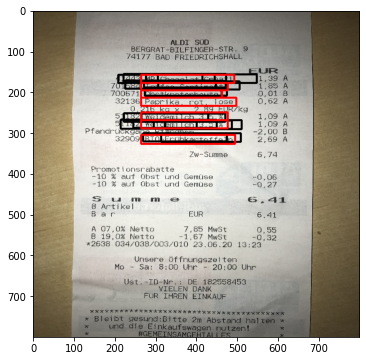

In [46]:
img_clone = np.copy(img)
roi_ocr = []
for i in range(pos_roi_per_this_image):
    roi_ocr.append(roi[pos_index[i]].astype(int))
    y0, x0, y1, x1 = roi[pos_index[i]].astype(int)
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(0, 0, 0), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(255, 0, 0), thickness=3) # Draw Rectangle

plt.figure(figsize=(9, 6))
plt.imshow(img_clone)
plt.show()  

In [47]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

bbox_for_sampled_roi = bbox[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)

height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width

base_height = bbox_for_sampled_roi[:, 2] - bbox_for_sampled_roi[:, 0]
base_width = bbox_for_sampled_roi[:, 3] - bbox_for_sampled_roi[:, 1]
base_ctr_y = bbox_for_sampled_roi[:, 0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 1] + 0.5 * base_width

(128, 4)
(128, 4)


In [48]:
height = np.maximum(height, eps)
width = np.maximum(width, eps)

dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)

gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs.shape)

(128, 4)


In [49]:
rois = torch.from_numpy(sample_roi).float()
roi_indices = 0 * np.ones((len(rois),), dtype=np.int32)
roi_indices = torch.from_numpy(roi_indices).float()
print(rois.shape, roi_indices.shape)

indices_and_rois = torch.cat([roi_indices[:, None], rois], dim=1)
xy_indices_and_rois = indices_and_rois[:, [0, 2, 1, 4, 3]]
indices_and_rois = xy_indices_and_rois.contiguous()
print(xy_indices_and_rois.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([128, 5])


In [50]:
size = (7, 7)
adaptive_max_pool = nn.AdaptiveMaxPool2d(size[0], size[1])

In [51]:
output = []
rois = indices_and_rois.data.float()
rois[:, 1:].mul_(1/16.0) # Subsampling ratio
rois = rois.long()
num_rois = rois.size(0)
for i in range(num_rois):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)
    output.append(tmp[0])
output = torch.cat(output, 0)
print(output.size())

torch.Size([128, 512, 7, 7])


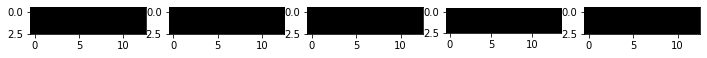

In [52]:
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = im[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

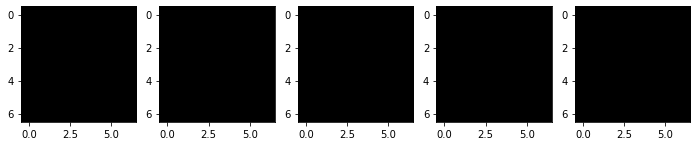

In [53]:
fig=plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    roi = rois[i]
    im_idx = roi[0]
    im = out_map.narrow(0, im_idx, 1)[..., roi[2]:(roi[4]+1), roi[1]:(roi[3]+1)]
    tmp = adaptive_max_pool(im)[0]
    tmp = tmp[0][0].detach().cpu().numpy()
    fig.add_subplot(1, 5, figNo) 
    plt.imshow(tmp, cmap='gray')
    figNo +=1
plt.show()

In [54]:
k = output.view(output.size(0), -1)
print(k.shape) # 25088 = 7*7*512

torch.Size([128, 25088])


In [55]:
roi_head_classifier = nn.Sequential(*[nn.Linear(25088, 4096), nn.Linear(4096, 4096)]).to(device)
cls_loc = nn.Linear(4096, 2 * 4).to(device)

cls_loc.weight.data.normal_(0, 0.01)
cls_loc.bias.data.zero_()

score = nn.Linear(4096, 2).to(device)

In [56]:
k = roi_head_classifier(k.to(device))
roi_cls_loc = cls_loc(k)
roi_cls_score = score(k)
print(roi_cls_loc.shape, roi_cls_score.shape)

torch.Size([128, 8]) torch.Size([128, 2])


In [57]:
print(roi_cls_loc.shape)
print(roi_cls_score.shape)

print(gt_roi_locs.shape)
print(gt_roi_labels.shape)

torch.Size([128, 8])
torch.Size([128, 2])
(128, 4)
(128,)


In [58]:
gt_roi_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [59]:
gt_roi_loc = torch.from_numpy(gt_roi_locs)
gt_roi_label = torch.from_numpy(np.float32(gt_roi_labels)).long()
print(gt_roi_loc.shape, gt_roi_label.shape)

roi_cls_loss = F.cross_entropy(roi_cls_score.cpu(), gt_roi_label.cpu(), ignore_index=-1)
print(roi_cls_loss.shape)

torch.Size([128, 4]) torch.Size([128])
torch.Size([])


In [60]:
n_sample = roi_cls_loc.shape[0]
roi_loc = roi_cls_loc.view(n_sample, -1, 4)
print(roi_loc.shape)

roi_loc = roi_loc[torch.arange(0, n_sample).long(), gt_roi_label]
print(roi_loc.shape)

pos = gt_roi_label > 0
mask = pos.unsqueeze(1).expand_as(roi_loc)
print(mask.shape)

mask_loc_preds = roi_loc[mask].view(-1, 4)
mask_loc_targets = gt_roi_loc[mask].view(-1, 4)
print(mask_loc_preds.shape, mask_loc_targets.shape)

x = torch.abs(mask_loc_targets.cpu() - mask_loc_preds.cpu())
roi_loc_loss = ((x < 1).float() * 0.5 * x**2) + ((x >= 1).float() * (x-0.5))
print(roi_loc_loss.sum())

torch.Size([128, 2, 4])
torch.Size([128, 4])
torch.Size([128, 4])
torch.Size([16, 4]) torch.Size([16, 4])
tensor(0.6473, dtype=torch.float64, grad_fn=<SumBackward0>)


In [61]:
roi_lambda = 10.
roi_loss = roi_cls_loss + (roi_lambda * roi_loc_loss)
print(roi_loss)

tensor([[0.7118, 0.6983, 0.7221, 0.6956],
        [0.8097, 0.8372, 0.6922, 0.7309],
        [1.1007, 0.6954, 0.7192, 0.6988],
        [0.7863, 1.1872, 0.6922, 0.7333],
        [0.6993, 1.4402, 0.6926, 0.8181],
        [0.7006, 0.8775, 0.8719, 0.7655],
        [0.7053, 1.1335, 0.6924, 0.6999],
        [0.8675, 0.7312, 0.7354, 0.7139],
        [0.9137, 0.7134, 0.7161, 0.6927],
        [0.7010, 1.5195, 0.7093, 0.6994],
        [0.9799, 1.0031, 0.7993, 0.7087],
        [0.6946, 0.7112, 0.7162, 0.7846],
        [0.7371, 0.8353, 0.6922, 0.7048],
        [0.6951, 0.8681, 0.6963, 0.7007],
        [0.7349, 0.7968, 0.7998, 0.7010],
        [0.8633, 0.8279, 0.7102, 0.6922]], dtype=torch.float64,
       grad_fn=<AddBackward0>)


In [62]:
total_loss = rpn_loss.to(device) + roi_loss.to(device)
print(total_loss)

tensor([[1.7695, 1.7560, 1.7798, 1.7533],
        [1.8673, 1.8948, 1.7499, 1.7886],
        [2.1584, 1.7531, 1.7768, 1.7565],
        [1.8440, 2.2448, 1.7499, 1.7910],
        [1.7570, 2.4978, 1.7503, 1.8758],
        [1.7583, 1.9352, 1.9296, 1.8232],
        [1.7630, 2.1912, 1.7501, 1.7576],
        [1.9252, 1.7888, 1.7931, 1.7716],
        [1.9714, 1.7711, 1.7738, 1.7504],
        [1.7586, 2.5772, 1.7670, 1.7571],
        [2.0376, 2.0608, 1.8570, 1.7663],
        [1.7523, 1.7689, 1.7739, 1.8423],
        [1.7948, 1.8930, 1.7499, 1.7624],
        [1.7527, 1.9258, 1.7540, 1.7584],
        [1.7925, 1.8545, 1.8574, 1.7586],
        [1.9210, 1.8856, 1.7679, 1.7499]], device='cuda:0',
       dtype=torch.float64, grad_fn=<AddBackward0>)


In [63]:
# the Keyword Context Network
class KCN(nn.Module):
    def __init__(self, output_size, time_steps=20):
        super(KCN, self).__init__()
    
        self.time_steps = time_steps
        self.lstm = nn.LSTM(1,128, bidirectional=True, num_layers=2)
        self.linear = nn.Linear(128*2*time_steps, output_size)
        #self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):        
        lstm_out, _ = self.lstm(x)
        tag_space = self.linear(lstm_out.view(-1,128*2*self.time_steps))
        return tag_space
    
    def pad_sequence(self, name, wordList, max_len=20):
        x = np.zeros((len(name), max_len))
        for i, name in enumerate(wordList):
            for j, c in enumerate(name):
                if j >= max_len:
                    break
                x[i,j] = ord(c)
        return torch.FloatTensor(x)
    
    def predict(self, word):
        probs = self(self.pad_sequence([word.upper()],[word.upper()]).view(1,20,1))
        if probs[0][0] > probs[0][1]:
            return 0
        else:
            return 1

In [64]:
# the ocr component build using tesseract
class OCR(object):
    def __init__(self, language):
        super(OCR, self).__init__()
        
        self.language = language
    
    def getString(self, image, boundingBox):
        y0, x0, y1, x1 = np.array(boundingBox)
        h = y1-y0
        w = x1-x0
        res = image[y0:y0+h,x0:x0+w]
        return pytesseract.image_to_string(res,lang=self.language)

In [65]:
ocr = OCR("deu")

In [66]:
roi_ocr_resized = []
for box in roi_ocr:
    box = [int(a * 1/b) for a, b in zip(box, ratioLst)] 
    roi_ocr_resized.append(box)
    
roi_ocr_resized = np.array(roi_ocr_resized)

In [67]:
import re
roi_to_words = []
regex = re.compile('[^a-zA-Z äÄüÜöÖ]')
for i in range(pos_roi_per_this_image):
    s = ocr.getString(img0, roi_ocr_resized[i].astype(int))
    res = regex.sub('', s).upper()
    roi_to_words.append(res)
print(roi_to_words)

['IDEMILCH  ', 'VA RATEFRILHKARTOFFELN', 'IN RE EZ IE INDHERTLRMATAMLATA', ' WEIDEMILCH ', ' WEIDEMILCH', 'EMILCH  ', ' MR CHOCOLAT CR', 'U NT A AR RN REFOREN SARTTIMENT', 'EEE ETBIN FRESE O', ' MR CHOCOLAT', 'EM N A UAD TAFFAA ERNRTIMAT', 'MR CHOCOLAT CREA', 'CHOCOLAT CREATI', ' WEIDEMILCH ', 'UN FE ER  U RE MW A U HSAA SORTIMENT', 'YEIDEMILCH  ']


In [68]:
kcn = KCN(2)
kcn.load_state_dict(torch.load("kcn.pth"))
kcn.eval()

KCN(
  (lstm): LSTM(1, 128, num_layers=2, bidirectional=True)
  (linear): Linear(in_features=5120, out_features=2, bias=True)
)

In [69]:
roi_ocr_mask = []
for word in roi_to_words:
    roi_ocr_mask.append(kcn.predict(word))
roi_ocr_mask = np.array(roi_ocr_mask)
print(roi_ocr_mask)

[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
